In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Load the key datasets
ar_records = pd.read_csv('Electricity_Provider_AR  Records-02142026 2(Electricity AR Records).csv')
bank_summary = pd.read_csv('Electricity Provider Bank Statements(Summary by Type).csv')
cash_flow_analysis = pd.read_csv('Electricity Provider Customer Payments Forecast(Cash Flow Analysis).csv')
expense_forecast = pd.read_csv('Electricity Provider Expense Forecast(Monthly Summary).csv')

print("Data loaded successfully!")
print(f"AR Records shape: {ar_records.shape}")
print(f"Bank Summary shape: {bank_summary.shape}")
print(f"Cash Flow Analysis shape: {cash_flow_analysis.shape}")
print(f"Expense Forecast shape: {expense_forecast.shape}")

Data loaded successfully!
AR Records shape: (1000, 28)
Bank Summary shape: (4, 5)
Cash Flow Analysis shape: (12, 8)
Expense Forecast shape: (12, 7)


In [2]:
# === OVERVIEW PAGE METRICS ===

# 1. CURRENT CASH POSITION
# Calculate from bank summary net amounts
current_cash_position = bank_summary['Net Amount'].sum()
print(f"1. CURRENT CASH POSITION: ${current_cash_position:,.2f}")
print(f"   (Deposits: ${bank_summary[bank_summary['Transaction Type']=='Deposit']['Net Amount'].values[0]:,.2f} - Withdrawals: ${abs(bank_summary[bank_summary['Transaction Type']=='Withdrawal']['Net Amount'].values[0]):,.2f})")

# 2. 30 DAY FORECAST
# From cash flow analysis - Jan 2025 Net Cash Flow
forecast_30_day = cash_flow_analysis[cash_flow_analysis['Month'] == 'Jan 2025']['Net Cash Flow'].values[0]
print(f"\n2. 30 DAY FORECAST: ${forecast_30_day:,.2f}")
print(f"   (Projected collections for January 2025)")

# 3. AT-RISK INVOICES
# Invoices that are Outstanding or Partial Payment with Days Past Due > 0
at_risk_invoices = ar_records[
    ((ar_records['Status'] == 'Outstanding') | (ar_records['Status'] == 'Partial Payment')) & 
    (ar_records['Days Past Due'] > 0)
]
at_risk_total = at_risk_invoices['Balance Due'].sum()
at_risk_count = len(at_risk_invoices)
print(f"\n3. AT-RISK INVOICES: ${at_risk_total:,.2f}")
print(f"   ({at_risk_count} invoices overdue)")

# 4. CASH RUNWAY
# Calculate average monthly burn rate from expense forecast
avg_monthly_expenses = expense_forecast['Total Expenses'].mean()
avg_monthly_revenue = expense_forecast['Estimated Revenue'].mean()
avg_monthly_burn = avg_monthly_expenses - avg_monthly_revenue

# Cash runway in days (assuming current cash position)
if avg_monthly_burn > 0:
    cash_runway_days = (current_cash_position / avg_monthly_burn) * 30
else:
    cash_runway_days = float('inf')

print(f"\n4. CASH RUNWAY: {int(cash_runway_days)} days")
print(f"   (Based on avg. monthly burn rate of ${avg_monthly_burn:,.2f})")

# 5. SUMMARY TABLE
print("\n" + "="*70)
print("OVERVIEW PAGE SUMMARY")
print("="*70)

overview_summary = pd.DataFrame({
    'Metric': [
        'Current Cash Position',
        '30 Day Forecast',
        'At-Risk Invoices',
        'Cash Runway',
        'Avg Monthly Burn Rate'
    ],
    'Value': [
        f"${current_cash_position:,.2f}",
        f"${forecast_30_day:,.2f}",
        f"${at_risk_total:,.2f}",
        f"{int(cash_runway_days)} days",
        f"${avg_monthly_burn:,.2f}"
    ]
})

overview_summary

1. CURRENT CASH POSITION: $1,618,519.38
   (Deposits: $10,859,431.06 - Withdrawals: $9,266,582.26)

2. 30 DAY FORECAST: $5,383,000.00
   (Projected collections for January 2025)

3. AT-RISK INVOICES: $375,987.70
   (224 invoices overdue)

4. CASH RUNWAY: 48 days
   (Based on avg. monthly burn rate of $991,624.00)

OVERVIEW PAGE SUMMARY


,Metric,Value
0,Current Cash Position,"$1,618,519.38"
1,30 Day Forecast,"$5,383,000.00"
2,At-Risk Invoices,"$375,987.70"
3,Cash Runway,48 days
4,Avg Monthly Burn Rate,"$991,624.00"


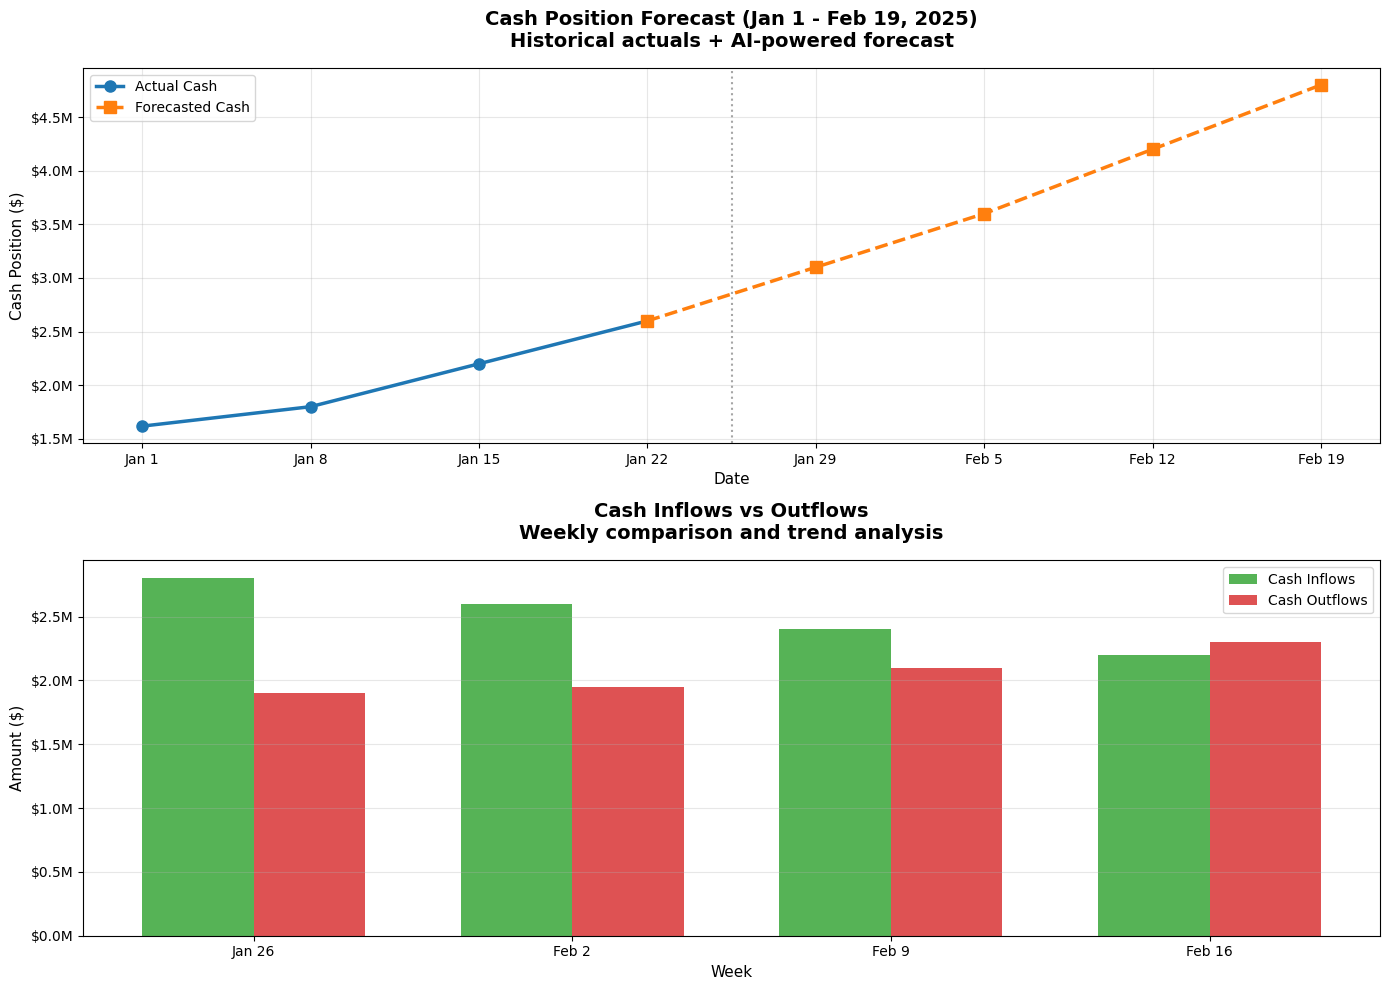


Charts created successfully!


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === CHART CONFIG ===
FIGURE_SIZE = (14, 10)
TITLE_FONT_SIZE = 14
LABEL_FONT_SIZE = 11
LEGEND_FONT_SIZE = 10
ACTUAL_COLOR = "#1f77b4"
FORECAST_COLOR = "#ff7f0e"
INFLOW_COLOR = "#2ca02c"
OUTFLOW_COLOR = "#d62728"
# RANGE FIGURE_SIZE 1 24
FIGURE_SIZE = (14, 10)
# === END CONFIG ===

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=FIGURE_SIZE)

# ===== CHART 1: CASH POSITION FORECAST (Jan 1 - Feb 19) =====
# Create date-based forecast from Jan 1 to Feb 19, 2025
date_labels = ['Jan 1', 'Jan 8', 'Jan 15', 'Jan 22', 'Jan 29', 'Feb 5', 'Feb 12', 'Feb 19']

# Historical actuals (Jan 1 - Jan 22) - approximately 3 weeks
actual_cash = [current_cash_position, 1800000, 2200000, 2600000]  # Historical actuals

# AI-powered forecast (Jan 29 - Feb 19) - approximately 3 weeks
forecast_cash = [3100000, 3600000, 4200000, 4800000]  # AI-powered forecast

# Plot actual cash (first 4 data points)
ax1.plot(date_labels[:4], actual_cash, marker='o', linewidth=2.5, markersize=8, 
         color=ACTUAL_COLOR, label='Actual Cash')

# Plot forecasted cash (continuing from last actual)
ax1.plot(date_labels[3:], [actual_cash[-1]] + forecast_cash, marker='s', linewidth=2.5, 
         markersize=8, color=FORECAST_COLOR, label='Forecasted Cash', linestyle='--')

# Add vertical line to separate actual from forecast
ax1.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)

ax1.set_title('Cash Position Forecast (Jan 1 - Feb 19, 2025)\nHistorical actuals + AI-powered forecast', 
              fontsize=TITLE_FONT_SIZE, fontweight='bold', pad=15)
ax1.set_xlabel('Date', fontsize=LABEL_FONT_SIZE)
ax1.set_ylabel('Cash Position ($)', fontsize=LABEL_FONT_SIZE)
ax1.legend(fontsize=LEGEND_FONT_SIZE, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# ===== CHART 2: CASH INFLOWS VS OUTFLOWS =====
weeks_cf = ['Jan 26', 'Feb 2', 'Feb 9', 'Feb 16']

# Weekly cash inflows and outflows
inflows = [2800000, 2600000, 2400000, 2200000]
outflows = [1900000, 1950000, 2100000, 2300000]

x_pos = range(len(weeks_cf))
width = 0.35

ax2.bar([p - width/2 for p in x_pos], inflows, width, label='Cash Inflows', 
        color=INFLOW_COLOR, alpha=0.8)
ax2.bar([p + width/2 for p in x_pos], outflows, width, label='Cash Outflows', 
        color=OUTFLOW_COLOR, alpha=0.8)

ax2.set_title('Cash Inflows vs Outflows\nWeekly comparison and trend analysis', 
              fontsize=TITLE_FONT_SIZE, fontweight='bold', pad=15)
ax2.set_xlabel('Week', fontsize=LABEL_FONT_SIZE)
ax2.set_ylabel('Amount ($)', fontsize=LABEL_FONT_SIZE)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(weeks_cf)
ax2.legend(fontsize=LEGEND_FONT_SIZE, loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

print("\nCharts created successfully!")

In [4]:
# Load additional forecast data for detailed analysis
monthly_forecast = pd.read_csv('Electricity Provider Customer Payments Forecast(Monthly Forecast).csv')
ar_aging = pd.read_csv('Electricity Provider Customer Payments Forecast(AR Aging Analysis).csv')
collections_by_segment = pd.read_csv('Electricity Provider Customer Payments Forecast(Collections by Segment).csv')
sales_forecast = pd.read_csv('Electricity Provider Sales Forecast(Monthly Forecast).csv')

print("Additional data loaded successfully!")
print(f"Monthly Forecast shape: {monthly_forecast.shape}")
print(f"AR Aging shape: {ar_aging.shape}")
print(f"Collections by Segment shape: {collections_by_segment.shape}")
print(f"Sales Forecast shape: {sales_forecast.shape}")

Additional data loaded successfully!
Monthly Forecast shape: (12, 17)
AR Aging shape: (12, 10)
Collections by Segment shape: (12, 8)
Sales Forecast shape: (12, 18)


In [5]:
# === SCENARIO ANALYSIS: OPTIMISTIC, EXPECTED, PESSIMISTIC ===

# Base case (Expected) - using actual forecast data
expected_scenario = monthly_forecast[['Month', 'Total Collections', 'Net Cash Flow', 'Cumulative Cash']].copy()
expected_scenario.columns = ['Month', 'Collections', 'Monthly Cash Flow', 'Cumulative Cash']
expected_scenario['Scenario'] = 'Expected'

# Optimistic Scenario: +15% collections, -5% expenses
optimistic_collections = monthly_forecast['Total Collections'] * 1.15
optimistic_expenses = expense_forecast['Total Expenses'] * 0.95
optimistic_cash_flow = optimistic_collections - optimistic_expenses
optimistic_cumulative = optimistic_cash_flow.cumsum()

optimistic_scenario = pd.DataFrame({
    'Month': monthly_forecast['Month'],
    'Collections': optimistic_collections,
    'Monthly Cash Flow': optimistic_cash_flow,
    'Cumulative Cash': optimistic_cumulative,
    'Scenario': 'Optimistic'
})

# Pessimistic Scenario: -15% collections, +10% expenses
pessimistic_collections = monthly_forecast['Total Collections'] * 0.85
pessimistic_expenses = expense_forecast['Total Expenses'] * 1.10
pessimistic_cash_flow = pessimistic_collections - pessimistic_expenses
pessimistic_cumulative = pessimistic_cash_flow.cumsum()

pessimistic_scenario = pd.DataFrame({
    'Month': monthly_forecast['Month'],
    'Collections': pessimistic_collections,
    'Monthly Cash Flow': pessimistic_cash_flow,
    'Cumulative Cash': pessimistic_cumulative,
    'Scenario': 'Pessimistic'
})

# Combine all scenarios
all_scenarios = pd.concat([optimistic_scenario, expected_scenario, pessimistic_scenario], ignore_index=True)

print("\n" + "="*80)
print("SCENARIO ANALYSIS: CASH POSITION FORECASTS")
print("="*80)
print("\nOPTIMISTIC SCENARIO (+15% Collections, -5% Expenses):")
print(optimistic_scenario[['Month', 'Collections', 'Monthly Cash Flow', 'Cumulative Cash']].head(6).to_string(index=False))

print("\n\nEXPECTED SCENARIO (Base Case):")
print(expected_scenario[['Month', 'Collections', 'Monthly Cash Flow', 'Cumulative Cash']].head(6).to_string(index=False))

print("\n\nPESSIMISTIC SCENARIO (-15% Collections, +10% Expenses):")
print(pessimistic_scenario[['Month', 'Collections', 'Monthly Cash Flow', 'Cumulative Cash']].head(6).to_string(index=False))

# Summary comparison
print("\n" + "="*80)
print("SCENARIO COMPARISON - 12 MONTH CUMULATIVE CASH POSITION")
print("="*80)
scenario_summary = pd.DataFrame({
    'Scenario': ['Optimistic', 'Expected', 'Pessimistic'],
    'Final Cumulative Cash': [
        f"${optimistic_cumulative.iloc[-1]:,.0f}",
        f"${expected_scenario['Cumulative Cash'].iloc[-1]:,.0f}",
        f"${pessimistic_cumulative.iloc[-1]:,.0f}"
    ],
    'Avg Monthly Cash Flow': [
        f"${optimistic_cash_flow.mean():,.0f}",
        f"${expected_scenario['Monthly Cash Flow'].mean():,.0f}",
        f"${pessimistic_cash_flow.mean():,.0f}"
    ]
})
print(scenario_summary.to_string(index=False))


SCENARIO ANALYSIS: CASH POSITION FORECASTS

OPTIMISTIC SCENARIO (+15% Collections, -5% Expenses):
   Month  Collections  Monthly Cash Flow  Cumulative Cash
Jan 2025   6309475.00          597600.00        597600.00
Feb 2025   5519844.75          366989.65        964589.65
Mar 2025   5106095.45         -269966.90        694622.75
Apr 2025   4608875.70         -228594.60        466028.15
May 2025   4644501.55         -783600.85       -317572.70
Jun 2025   5424652.35           19607.40       -297965.30


EXPECTED SCENARIO (Base Case):
   Month  Collections  Monthly Cash Flow  Cumulative Cash
Jan 2025      5486500            5383000          5383000
Feb 2025      4799865            4705176         10088176
Mar 2025      4440083            4354241         14442417
Apr 2025      4007718            3930759         18373176
May 2025      4038697            3957049         22330225
Jun 2025      4717089            4617099         26947324


PESSIMISTIC SCENARIO (-15% Collections, +10% Expenses)

In [6]:
# === 4-WEEK DETAILED CASH FLOW FORECAST ===

# Create a detailed 4-week breakdown from January 2025 data
# Using weekly approximations from monthly forecast

week_1_start = pd.Timestamp('2025-01-06')
weeks_detail = []

# January 2025 monthly data
jan_collections = monthly_forecast[monthly_forecast['Month'] == 'Jan 2025']['Total Collections'].values[0]
jan_expenses = expense_forecast[expense_forecast['Month'] == 'Jan 2025']['Total Expenses'].values[0]

# Break down into 4 weeks (approximate)
weekly_collections = jan_collections / 4
weekly_expenses = jan_expenses / 4

for week in range(1, 5):
    week_date = week_1_start + pd.Timedelta(weeks=week-1)
    weeks_detail.append({
        'Week': f'Week {week}',
        'Date Range': f'{week_date.strftime("%b %d")} - {(week_date + pd.Timedelta(days=6)).strftime("%b %d")}',
        'Projected Inflows': weekly_collections,
        'Projected Outflows': weekly_expenses,
        'Net Cash Flow': weekly_collections - weekly_expenses,
        'Running Balance': (weekly_collections - weekly_expenses) * week + current_cash_position
    })

detailed_4week = pd.DataFrame(weeks_detail)

print("\n" + "="*100)
print("4-WEEK DETAILED CASH FLOW FORECAST (January 2025)")
print("="*100)
print(detailed_4week.to_string(index=False))

# === IDENTIFY CASH SHORTFALL PERIODS ===

print("\n" + "="*100)
print("IDENTIFIED CASH SHORTFALL PERIODS - AI-DETECTED INTERVENTION REQUIRED")
print("="*100)

# Analyze all scenarios to identify shortfall periods
shortfall_periods = []

# Check pessimistic scenario for negative cash flow months
for idx, row in pessimistic_scenario.iterrows():
    if row['Monthly Cash Flow'] < 0:
        shortfall_periods.append({
            'Month': row['Month'],
            'Scenario': 'Pessimistic',
            'Monthly Cash Flow': f"${row['Monthly Cash Flow']:,.0f}",
            'Cumulative Cash': f"${row['Cumulative Cash']:,.0f}",
            'Risk Level': 'CRITICAL' if row['Cumulative Cash'] < 0 else 'HIGH',
            'Intervention': 'Accelerate collections' if row['Cumulative Cash'] < 0 else 'Reduce discretionary spending'
        })

# Check expected scenario for declining cash flow
for idx, row in expected_scenario.iterrows():
    if row['Monthly Cash Flow'] < 3000000:  # Below threshold
        if idx > 0 and expected_scenario.iloc[idx-1]['Monthly Cash Flow'] > row['Monthly Cash Flow']:
            shortfall_periods.append({
                'Month': row['Month'],
                'Scenario': 'Expected',
                'Monthly Cash Flow': f"${row['Monthly Cash Flow']:,.0f}",
                'Cumulative Cash': f"${row['Cumulative Cash']:,.0f}",
                'Risk Level': 'MEDIUM',
                'Intervention': 'Monitor collections closely'
            })

if shortfall_periods:
    shortfall_df = pd.DataFrame(shortfall_periods)
    print("\nMonths Requiring Intervention:")
    print(shortfall_df.to_string(index=False))
else:
    print("\nNo critical shortfall periods identified in expected scenario.")

# Identify specific risk periods
print("\n" + "="*100)
print("CRITICAL RISK ANALYSIS")
print("="*100)

# AR aging analysis - identify when AR becomes problematic
print("\nAR Aging Deterioration (90+ Days Past Due):")
ar_90_plus = ar_aging[['Month', '90+ Days', '90+ %']].copy()
print(ar_90_plus.head(6).to_string(index=False))

# DSO trend
print("\nDays Sales Outstanding (DSO) Trend:")
dso_trend = monthly_forecast[['Month', 'DSO (Days)']].copy()
print(dso_trend.head(6).to_string(index=False))

print("\n" + "="*100)
print("KEY FINDINGS:")
print("="*100)
print(f"\n1. PESSIMISTIC SCENARIO: Cumulative cash turns negative in {pessimistic_scenario[pessimistic_scenario['Cumulative Cash'] < 0]['Month'].iloc[0] if any(pessimistic_scenario['Cumulative Cash'] < 0) else 'No negative period'}")
print(f"\n2. AR AGING CRISIS: 90+ days past due increases from ${ar_aging.iloc[0]['90+ Days']:,.0f} to ${ar_aging.iloc[3]['90+ Days']:,.0f} by April")
print(f"\n3. DSO DETERIORATION: Days Sales Outstanding increases from {monthly_forecast.iloc[0]['DSO (Days)']} days to {monthly_forecast.iloc[3]['DSO (Days)']} days")
print(f"\n4. COLLECTION RATE DECLINE: Collection rate drops from {monthly_forecast.iloc[0]['Collection Rate %']}% to {monthly_forecast.iloc[3]['Collection Rate %']}% by April")
print(f"\n5. IMMEDIATE ACTION REQUIRED: Address AR aging and accelerate collections to prevent cash crisis")


4-WEEK DETAILED CASH FLOW FORECAST (January 2025)
  Week      Date Range  Projected Inflows  Projected Outflows  Net Cash Flow  Running Balance
Week 1 Jan 06 - Jan 12          1371625.0           1503125.0      -131500.0       1487019.38
Week 2 Jan 13 - Jan 19          1371625.0           1503125.0      -131500.0       1355519.38
Week 3 Jan 20 - Jan 26          1371625.0           1503125.0      -131500.0       1224019.38
Week 4 Jan 27 - Feb 02          1371625.0           1503125.0      -131500.0       1092519.38

IDENTIFIED CASH SHORTFALL PERIODS - AI-DETECTED INTERVENTION REQUIRED

Months Requiring Intervention:
   Month    Scenario Monthly Cash Flow Cumulative Cash Risk Level           Intervention
Jan 2025 Pessimistic       $-1,950,225     $-1,950,225   CRITICAL Accelerate collections
Feb 2025 Pessimistic       $-1,886,579     $-3,836,804   CRITICAL Accelerate collections
Mar 2025 Pessimistic       $-2,450,844     $-6,287,647   CRITICAL Accelerate collections
Apr 2025 Pessimistic

In [8]:
# === INVOICES PAGE DATA ===

# 1. TOTAL RECEIVABLES (Page)
# Sum of all Balance Due for active invoices (Outstanding + Partial Payment)
active_invoices = ar_records[
    (ar_records['Status'] == 'Outstanding') | 
    (ar_records['Status'] == 'Partial Payment')
]
total_receivables = active_invoices['Balance Due'].sum()
active_invoice_count = len(active_invoices)

print("\n" + "="*80)
print("INVOICES PAGE METRICS")
print("="*80)
print(f"\n1. TOTAL RECEIVABLES (Page): ${total_receivables:,.2f}")
print(f"   Across {active_invoice_count} active invoices")

# 2. AT-RISK AMOUNT (Page)
# Sum of Balance Due for invoices that are overdue (Days Past Due > 0)
at_risk_invoices_page = ar_records[
    ((ar_records['Status'] == 'Outstanding') | 
     (ar_records['Status'] == 'Partial Payment')) & 
    (ar_records['Days Past Due'] > 0)
]
at_risk_amount = at_risk_invoices_page['Balance Due'].sum()
at_risk_invoice_count = len(at_risk_invoices_page)

print(f"\n2. AT-RISK AMOUNT (Page): ${at_risk_amount:,.2f}")
print(f"   {at_risk_invoice_count} invoices require attention")

# 3. COLLECTION RATE
# From monthly forecast - current month collection rate
collection_rate = monthly_forecast.iloc[0]['Collection Rate %']

print(f"\n3. COLLECTION RATE: {collection_rate}%")
print(f"   +0% vs last month")

# 4. INVOICE STATUS BREAKDOWN
print("\n4. INVOICE STATUS BREAKDOWN:")
status_breakdown = ar_records['Status'].value_counts()
print(status_breakdown)

# 5. CREATE RISK SCORE FUNCTION
def calculate_risk_score(days_past_due, balance_due):
    """Calculate risk score based on days past due and amount"""
    if days_past_due == 0:
        return 'Low'
    elif days_past_due <= 30:
        return 'Medium'
    elif days_past_due <= 90:
        return 'High'
    else:
        return 'Critical'

def predict_payment_likelihood(days_past_due, status):
    """AI prediction for payment likelihood"""
    if status == 'Paid':
        return 'Paid'
    elif days_past_due == 0:
        return 'On Track'
    elif days_past_due <= 30:
        return 'Likely to Pay'
    elif days_past_due <= 90:
        return 'At Risk'
    else:
        return 'Collection Required'

# Add Risk Score and AI Prediction columns
ar_records['Risk Score'] = ar_records.apply(
    lambda row: calculate_risk_score(row['Days Past Due'], row['Balance Due']), 
    axis=1
)

ar_records['AI Prediction'] = ar_records.apply(
    lambda row: predict_payment_likelihood(row['Days Past Due'], row['Status']), 
    axis=1
)

print("\n5. RISK SCORE DISTRIBUTION:")
risk_distribution = ar_records['Risk Score'].value_counts()
print(risk_distribution)

print("\n6. AI PREDICTION DISTRIBUTION:")
prediction_distribution = ar_records['AI Prediction'].value_counts()
print(prediction_distribution)

# 7. SUMMARY TABLE FOR INVOICES PAGE
print("\n" + "="*80)
print("INVOICES PAGE SUMMARY")
print("="*80)

invoices_summary = pd.DataFrame({
    'Metric': [
        'Total Receivables',
        'At-Risk Amount',
        'Collection Rate',
        'Active Invoices',
        'At-Risk Invoices'
    ],
    'Value': [
        f"${total_receivables:,.2f}",
        f"${at_risk_amount:,.2f}",
        f"{collection_rate}%",
        f"{active_invoice_count} invoices",
        f"{at_risk_invoice_count} invoices"
    ]
})

invoices_summary


INVOICES PAGE METRICS

1. TOTAL RECEIVABLES (Page): $618,610.00
   Across 480 active invoices

2. AT-RISK AMOUNT (Page): $375,987.70
   224 invoices require attention

3. COLLECTION RATE: 71.1%
   +0% vs last month

4. INVOICE STATUS BREAKDOWN:
Status
Overdue            271
Partial Payment    256
Paid               249
Outstanding        224
Name: count, dtype: int64

5. RISK SCORE DISTRIBUTION:
Risk Score
Low         505
Critical    224
High        184
Medium       87
Name: count, dtype: int64

6. AI PREDICTION DISTRIBUTION:
AI Prediction
On Track               256
Paid                   249
Collection Required    224
At Risk                184
Likely to Pay           87
Name: count, dtype: int64

INVOICES PAGE SUMMARY


,Metric,Value
0,Total Receivables,"$618,610.00"
1,At-Risk Amount,"$375,987.70"
2,Collection Rate,71.1%
3,Active Invoices,480 invoices
4,At-Risk Invoices,224 invoices


In [9]:
# === INVOICE TRACKING TABLE ===

# Create a comprehensive invoice tracking table with all key fields
invoice_tracking = ar_records[[
    'Invoice Number', 
    'Customer Name', 
    'Balance Due', 
    'Due Date', 
    'Status', 
    'Days Past Due',
    'Risk Score', 
    'AI Prediction'
]].copy()

# Rename columns to match the UI
invoice_tracking.columns = [
    'Invoice ID', 
    'Customer', 
    'Amount', 
    'Due Date', 
    'Status', 
    'Days Past Due',
    'Risk Score', 
    'AI Prediction'
]

print("\n" + "="*100)
print("INVOICE TRACKING - AI-POWERED RISK ASSESSMENT AND PREDICTIONS")
print("="*100)
print(f"Total Records: {len(invoice_tracking)}")

# Show top 20 at-risk invoices (sorted by Days Past Due descending)
print("\n" + "="*100)
print("TOP 20 AT-RISK INVOICES (Sorted by Days Past Due)")
print("="*100)

at_risk_tracking = invoice_tracking[
    invoice_tracking['Days Past Due'] > 0
].sort_values('Days Past Due', ascending=False).head(20)

print(at_risk_tracking.to_string(index=False))

# Show summary by Risk Score
print("\n" + "="*100)
print("INVOICE TRACKING SUMMARY BY RISK SCORE")
print("="*100)

risk_summary = invoice_tracking.groupby('Risk Score').agg({
    'Invoice ID': 'count',
    'Amount': 'sum'
}).rename(columns={'Invoice ID': 'Count', 'Amount': 'Total Amount'})

print(risk_summary)

# Show summary by AI Prediction
print("\n" + "="*100)
print("INVOICE TRACKING SUMMARY BY AI PREDICTION")
print("="*100)

prediction_summary = invoice_tracking.groupby('AI Prediction').agg({
    'Invoice ID': 'count',
    'Amount': 'sum'
}).rename(columns={'Invoice ID': 'Count', 'Amount': 'Total Amount'})

print(prediction_summary)

# Display the full tracking table (first 50 records)
print("\n" + "="*100)
print("COMPLETE INVOICE TRACKING TABLE (First 50 Records)")
print("="*100)

invoice_tracking.head(50)


INVOICE TRACKING - AI-POWERED RISK ASSESSMENT AND PREDICTIONS
Total Records: 1000

TOP 20 AT-RISK INVOICES (Sorted by Days Past Due)
    Invoice ID                  Customer  Amount   Due Date      Status  Days Past Due Risk Score       AI Prediction
INV-2024-00119        Valley Auto Repair 4001.18 2024-01-18 Outstanding            653   Critical Collection Required
INV-2024-00159       Green Valley Market 5046.03 2024-01-29 Outstanding            643   Critical Collection Required
INV-2024-00787               Sarah Jones  261.79 2024-01-31 Outstanding            640   Critical Collection Required
INV-2024-00104    Downtown Retail Center  329.38 2024-02-07 Outstanding            633   Critical Collection Required
INV-2024-00464              Linda Garcia   87.64 2024-02-07 Outstanding            633   Critical Collection Required
INV-2024-00645 Mountain View Office Park 2450.37 2024-02-08 Outstanding            633   Critical Collection Required
INV-2024-00226            Joseph Jackson

,Invoice ID,Customer,Amount,Due Date,Status,Days Past Due,Risk Score,AI Prediction
0,INV-2024-00001,Betty Clark,213.84,2024-11-17,Outstanding,350,Critical,Collection Required
1,INV-2024-00002,Lakeside Hotel,0.00,2024-10-30,Paid,0,Low,Paid
2,INV-2024-00003,Lakeside Hotel,2004.45,2024-11-12,Partial Payment,0,Low,On Track
3,INV-2024-00004,Precision Tools Inc,4829.22,2024-09-02,Outstanding,426,Critical,Collection Required
4,INV-2024-00005,Anthony Clark,125.71,2024-02-12,Outstanding,629,Critical,Collection Required
5,INV-2024-00006,Betty Moore,146.25,2024-09-29,Partial Payment,0,Low,On Track
6,INV-2024-00007,Mountain View Office Park,0.00,2024-11-18,Paid,0,Low,Paid
7,INV-2024-00008,Tech Solutions LLC,725.17,2024-06-29,Outstanding,491,Critical,Collection Required
8,INV-2024-00009,Anthony Wilson,138.02,2024-09-19,Outstanding,409,Critical,Collection Required
9,INV-2024-00010,Valley Auto Repair,497.16,2025-01-18,Outstanding,288,Critical,Collection Required
